# Facial Expression Recognition

* The data consists of 48x48 pixel grayscale images of faces. 
* The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. 
* The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories:
0. `Angry`
1. `Disgust` 
2. `Fear` 
3. `Happy`
4. `Sad`
5. `Surprise`,
6. `Neutral`

# Download Dataset

* For running on Google Colab

In [1]:
!pip install -q torchsummary

from google.colab import files
import os

print("Upload your kaggle.json file containing your API keys")
if not os.path.exists(r"/content/fer2018.zip"):
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle datasets download -d ashishpatel26/fer2018
    !unzip -qq  fer2018.zip -d datasets/

Upload your kaggle.json file containing your API keys


# Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")


import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from torchsummary import summary

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
pd.set_option('display.max_columns', 20)


%matplotlib inline

# Dataset Preparation

In [3]:
emotions = {
    0: 'Angry', 
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'
}

In [4]:
dataset = pd.read_csv('/content/datasets/fer20131.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [5]:
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
dataset.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

* We're going to use the `Training` and `PublicTest` rows combined together for training and validation set split into  80-20 proportion
* `PrivateTest` will be our final test dataset.

In [7]:
# extracting pixel data from pixel column
# convert it to integer
# drop original pixel column
# add all pixels as individual column

pixels = []

for pix in dataset.pixels:
    values = [int(i) for i in pix.split()]
    pixels.append(values)

pixels = np.array(pixels)

# rescaling pixel values
pixels = pixels/255.0


dataset.drop(columns=['pixels'], axis=1, inplace=True)

pix_cols = [] # for keeping track of column names

# add each pixel value as a column
for i in range(pixels.shape[1]):
    name = f'pixel_{i}'
    pix_cols.append(name)
    dataset[name] = pixels[:, i]

In [8]:
dataset.head()

,emotion,Usage,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,...,pixel_2294,pixel_2295,pixel_2296,pixel_2297,pixel_2298,pixel_2299,pixel_2300,pixel_2301,pixel_2302,pixel_2303
0,0,Training,0.274510,0.313725,0.321569,0.282353,0.227451,0.227451,0.235294,0.247059,...,0.623529,0.713725,0.717647,0.533333,0.415686,0.454902,0.372549,0.415686,0.427451,0.321569
1,0,Training,0.592157,0.588235,0.576471,0.607843,0.580392,0.521569,0.435294,0.549020,...,0.411765,0.423529,0.372549,0.423529,0.400000,0.262745,0.670588,0.756863,0.717647,0.721569
2,2,Training,0.905882,0.831373,0.611765,0.643137,0.682353,0.541176,0.631373,0.678431,...,0.407843,0.541176,0.596078,0.478431,0.447059,0.396078,0.380392,0.345098,0.431373,0.596078
3,4,Training,0.094118,0.125490,0.141176,0.117647,0.125490,0.090196,0.074510,0.078431,...,0.682353,0.494118,0.517647,0.517647,0.521569,0.533333,0.545098,0.556863,0.560784,0.556863
4,6,Training,0.015686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.047059,0.133333,0.121569,0.121569,0.121569,0.105882,0.121569,0.117647,0.113725,0.117647


# Dataset Class

In [9]:
class FERDataset(Dataset):
    '''
        Parse raw data to form a Dataset of (X, y).
    '''
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.tensor_transform = T.ToTensor()
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = int(row['emotion'])
        img = np.copy(row[pix_cols].values.reshape(48, 48))
        img.setflags(write=True)

        if self.transform:
            img = Image.fromarray(img)
            img = self.transform(img)
        else:
            img = self.tensor_transform(img)

        return img, img_id

# Data Imbalance

* To deal with class Imbalance we can try different image transformations
* We can also combine angry and disgust class as one as they are closely related.

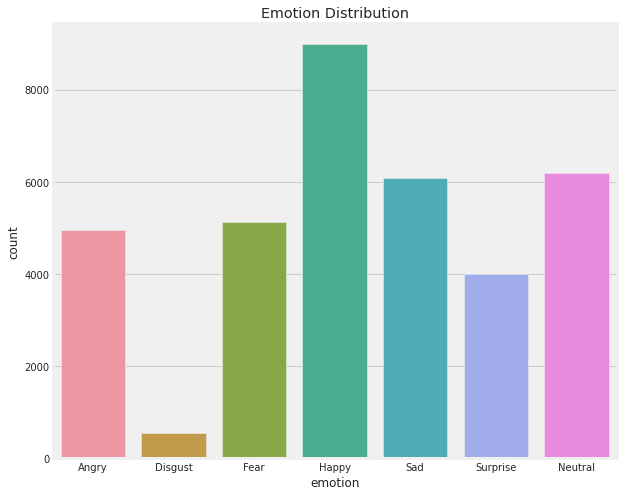

In [10]:
plt.figure(figsize=(9, 8))
sns.countplot(x=dataset.emotion)
_ = plt.title('Emotion Distribution')
_ = plt.xticks(ticks=range(0, 7), labels=[emotions[i] for i in range(0, 7)], )

In [11]:
# combine digust and angry classes

replacements = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}

dataset['emotion'] = dataset.emotion.replace(to_replace=replacements.keys(), value=replacements.values())

In [12]:
# update the emotions dictionary

emotions = {
    0: 'Angry', 
    1: 'Fear', 
    2: 'Happy', 
    3: 'Sad', 
    4: 'Surprise', 
    5: 'Neutral'
}

# Data Augmentations

* We're going to apply various augmentation techniques.
* All available transformations are listed in : [pytorch transforms](https://pytorch.org/docs/stable/torchvision/transforms.html)


In [13]:
def image_transformations() -> (object, object):
    '''
        Return transformations to be applied.
        Input:
            None
        Output:
            train_tfms: transformations to be applied on the training set
            valid_tfms: transformations to be applied on the validation or test set
    '''

    train_trans = [      
        T.RandomRotation(15),
        T.RandomAffine(
            degrees=0,
            translate=(0.01, 0.12),
            shear=(0.01, 0.03),
        ),
        T.RandomHorizontalFlip(),
        T.RandomCrop(48, padding=8, padding_mode='reflect'),     
        T.ToTensor(),
    ]

    val_trans = [
        T.ToTensor(), 
    ]

    train_transformations = T.Compose(train_trans)
    valid_tfms = T.Compose(val_trans)

    return train_transformations, valid_tfms

# Dataset and Dataloader

In [14]:
def get_train_dataset(dataframe: object, transformation: bool=True) -> (object, object):
    '''
        Returns an object on FERDataset class
        Input:
            dataframe: object -> DataFrame object containing the whole data
            transformation: bool [optional] ->  Apply transformations
    '''

    # extracts rows specific to Training, PublicTest
    dataframe = dataframe.loc[dataframe.Usage.isin(['Training', 'PublicTest'])]
    # drop Usage column as it's no longer needed    
    dataframe = dataframe.drop('Usage', axis=1)

    # split dataset into training and validation set
    np.random.seed(42)  
    msk = np.random.rand(len(dataframe)) < 0.8

    train_df = dataframe[msk].reset_index()
    val_df = dataframe[~msk].reset_index()

    # get transformations
    if transformation:
        train_tfms, valid_tfms = image_transformations()
    else:
        train_tfms, valid_tfms = None, None

    # fetch dataset
    train_ds = FERDataset(dataframe, transform=train_tfms)
    val_ds = FERDataset(dataframe, transform=valid_tfms)
    return train_ds, val_ds

In [15]:
def get_train_dataloader(dataframe: object, transformation=True, batch_size: int=64) -> (object, object):
    '''
        Returns train and test dataloaders.
        Input:
            dataframe: dataset DataFrame object
            batch_size: [optional] int
        Output:
            train_dl: train dataloader object
            valid_dl: validation dataloader object
    '''
    # fetech train and validation dataset
    train_ds, valid_ds = get_train_dataset(dataframe, transformation=transformation)
    
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                     num_workers=3, pin_memory=True)
    valid_dl = DataLoader(valid_ds, batch_size*2, 
                    num_workers=2, pin_memory=True)
    
    return train_dl, valid_dl

In [16]:
def get_test_dataloader(dataframe: object, batch_size: int=128) -> object:
    '''
        Returns test set dataloaders.
        Input:
            dataframe: dataset DataFrame object
            batch_size: [optional] int
        Output:
            test_dl: test dataloader object
    '''
    # extracts rows specific to PrivateTest
    test_df = dataframe.loc[dataset.Usage.isin(['PrivateTest'])]

    # drop Usage column as it's no longer needed
    test_df = test_df.drop('Usage', axis=1)

    # get transformations same as validation set
    _, valid_tfms = image_transformations()
    
    test_dataset = FERDataset(test_df, transform=valid_tfms)
    test_dl = DataLoader(test_dataset, batch_size, num_workers=3 , pin_memory=True)

    # move loader to GPU (class defined ahead)
    test_dl = DeviceDataLoader(test_dl, device)
    return test_dl

# Visualization

In [17]:
train_dl_un, _ = get_train_dataloader(dataset, transformation=False)
train_dl, _ = get_train_dataloader(dataset)

images.shape: torch.Size([64, 1, 48, 48])


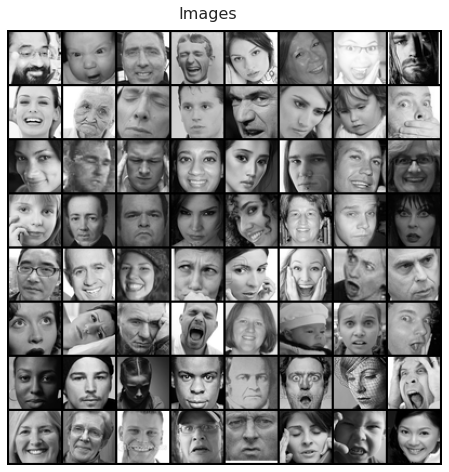

In [18]:
for images, _ in train_dl_un:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0))) # move the channel dimension
    break

_ = plt.suptitle("Images", y=0.92, fontsize=16)

images.shape: torch.Size([64, 1, 48, 48])


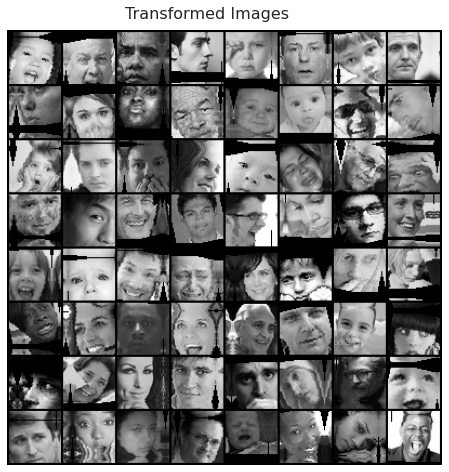

In [19]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0))) # move the channel dimension
    break

_ = plt.suptitle("Transformed Images", y=0.92, fontsize=16)

# Setting up GPU usage

In [20]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
device = get_default_device()
device

device(type='cuda')

# Model Building

## Base Image Classification Class

In [22]:
# Can be used for any Image Classification task

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        acc = accuracy(outputs, labels)
        return {'loss': loss, 'acc': acc.detach()}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def get_metrics_epoch_end(self, outputs, validation=True):
        if validation:
            loss_ = 'val_loss'
            acc_ = 'val_acc'
        else:
            loss_ = 'loss'
            acc_ = 'acc'

        batch_losses = [x[f'{loss_}'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x[f'{acc_}'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {f'{loss_}': epoch_loss.detach().item(), f'{acc_}': epoch_acc.detach().item()}

    def epoch_end(self, epoch, result, num_epochs):
        print(f"Epoch: {epoch+1}/{num_epochs} -> loss: {result['loss']:.4f}, acc: {result['acc']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}\n")

## Metric

In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

## Model: ResNet-9 

In [24]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [
              nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)
    ]

    if pool:
        layers.append(nn.MaxPool2d(kernel_size=2))
    
    return nn.Sequential(*layers)

In [25]:
# updated channels for the use case
# added and additional layer in classifier

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = conv_block(in_channels, 16, pool=False) # 16 x 48 x 48
        self.conv2 = conv_block(16, 32, pool=True) # 32 x 24 x 24
        self.res1 = nn.Sequential( #  32 x 24 x 24
            conv_block(32, 32, pool=False), 
            conv_block(32, 32, pool=False)
        )

        self.conv3 = conv_block(32, 64, pool=True) # 64 x 12 x 12
        self.conv4 = conv_block(64, 128, pool=True) # 128 x 6 x 6

        self.res2 = nn.Sequential( # 128 x 6 x 6
             conv_block(128, 128), 
             conv_block(128, 128)
        )
        
        self.classifier = nn.Sequential(
            nn.MaxPool2d(kernel_size=2), # 128 x 3 x 3
            nn.Flatten(),
            nn.Linear(128*3*3, 512), #512
            nn.Linear(512, num_classes) # 7
        )
        self.network = nn.Sequential(
            self.conv1,
            self.conv2,
            self.res1,
            self.conv3,
            self.conv4,
            self.res2,
            self.classifier,
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out       

    def __repr__(self):
        return f"{self.network}"
    
    def __str__(self):
        summary(self.network, (1, 48, 48)) 

## Model: From scratch

In [26]:
class EmotionRecognition(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.network = nn.Sequential( #1 x 48 x 48
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 24 x 24
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 12 x 12
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 6 x 6
            nn.BatchNorm2d(128),

            nn.Flatten(), 
            nn.Linear(128*6*6, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes))
        
    def forward(self, xb):
        return self.network(xb)

    def __repr__(self):
        return f"{self.network}"
    
    def __str__(self):
        summary(self.network, (1, 48, 48))

# Setup Training

## Helper Functions

In [27]:
@torch.no_grad()
def evaluate(model: object, val_loader: object) -> dict:
    '''
        Evaluate model on the validation set
        Input:
            model: training model object
            val_loder: validation data loader object
        Output:
            validation metrics
    '''

    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.get_metrics_epoch_end(outputs=outputs, validation=True)


def fit_model(model_name: str,
              model: object, 
              epochs: int,
              lr: float,
              train_loader: object, 
              val_loader: object,
              opt_func: object=torch.optim.SGD):
    '''
        This function is responsible for training our model.
        We use a One Cycle learning rate policy to update our learning rate 
        with each epoch.
        The best model is saved during each epoch.
        Input:
            model_name: str 
            model: object
            epochs: int -> Max epochs
            train_loader: training set data loader
            val_loader: validation set data loader
            opt_func: optimzer object
        Output:
            history: list of metrics
    '''

    torch.cuda.empty_cache()
    BEST_VAL_SCORE = 0.0 # for keeping track of best model score
    history = []
    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):
        train_history = []
        # Training Phase 
        model.train()
        for batch in tqdm(train_loader, desc=f"Epoch: {epoch+1}/{epochs}"):
            info = model.training_step(batch)
            loss = info['loss']
            # contains batch loss and acc for training phase
            train_history.append(info)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_result = model.get_metrics_epoch_end(train_history, validation=False)
        val_result = evaluate(model, val_loader)
        result = {**train_result, **val_result}
        model.epoch_end(epoch, result, epochs)

        # Save the best model
        if result['val_acc'] > BEST_VAL_SCORE:
            BEST_VAL_SCORE = result['val_acc']
            save_name = f"{model_name}_epoch-{epoch+1}_score-{round(result['val_acc'], 4)}.pth"
            !rm -f '{model_name}'_*
            torch.save(model.state_dict(), save_name)

        history.append(result)
    return history

In [28]:
# functions to fetch test dataset and generate submission file for best model

def load_best(model_name: str) -> object:
    '''Returns the best model'''

    # get model defintion
    best_model = models[model_name]

    # load trained weights
    path = r"/content/"
    file_path = ''
    
    for i in os.listdir(path):
        if os.path.isfile(os.path.join(path,i)) and i.startswith(f'{model_name}'):
            file_path = os.path.join(path, i)
            
    print(f"Loaded model: {file_path[9:]} weights.")
    best_model.load_state_dict(torch.load(file_path))

    # move model to gpu
    best_model = to_device(best_model, device)
    return best_model   


@torch.no_grad()
def generate_prediction(model_name: str) -> None:
    '''Generate prediction on the test set'''

    # load test dataset
    test_dl = get_test_dataloader(dataset)
    
    # load model
    model = load_best(model_name)

    # clear cuda cache
    torch.cuda.empty_cache()

    # generate prediction using the validation step method defined in Base class
    with torch.no_grad():
        model.eval()
        outputs = [model.validation_step(batch) for batch in test_dl]
        metrics = model.get_metrics_epoch_end(outputs=outputs, validation=True)

    print(f"Test Scores:\n Loss: {round(metrics['val_loss'], 3)}, Accuracy: {round(metrics['val_acc'], 3)}")

In [29]:
def end_to_end(model_name: str, parameters: dict=None) -> dict:
    '''
        A simple function end-to-end training and testing on the selected model.
        Inputs:
            model_name: str -> chosen model name
            parameters: dict -> dictionary of hyperparameters for the model
        Outputs:
            history: dict -> dictionary containing model metrics(loss, score, lr)

    '''
    torch.cuda.empty_cache()

    # hyperparameters
    BATCH_SIZE = parameters["batch_size"]
    epochs = parameters["epochs"]
    lr = parameters["lr"]
    opt_func = parameters["opt_func"]

    # get transformed dataset
    train_dl, valid_dl = get_train_dataloader(dataset, batch_size=BATCH_SIZE)
    # move dataset to use GPU
    train_dl = DeviceDataLoader(train_dl, device)
    valid_dl = DeviceDataLoader(valid_dl, device)

    # get model
    model = models[model_name]

    # move model to GPU
    model = to_device(model, device)
    
    # train model
    history = fit_model(
                model_name,
                model, 
                epochs, 
                lr,
                train_dl, 
                valid_dl,
                opt_func
            )

    # cleaning
    torch.cuda.empty_cache()

    # generate predictions
    print("Genearating predictions on the Test set")
    generate_prediction(model_name)
    return history

In [30]:
# plotting metrics

def plot_accuracies(history):
    train_acc = [r['acc'] for r in history]
    val_acc = [r['val_acc'] for r in history]
    plt.plot(train_acc, '-kx', label="train_acc")
    plt.plot(val_acc, '-rx', label="val_acc")
    plt.legend()
    _ = plt.xticks(ticks=range(len(train_acc)), 
                   labels=[str(i) for i in range(1, len(train_acc)+1)])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. epochs')

def plot_losses(history):
    train_losses = [r['loss'] for r in history]
    val_losses = [r['val_loss'] for r in history]
    plt.plot(train_losses, '-kx', label="train_loss")
    plt.plot(val_losses, '-rx', label="val_loss")
    plt.legend()
    _ = plt.xticks(ticks=range(len(train_losses)), 
                   labels=[str(i) for i in range(1, len(train_losses)+1)])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. epochs')

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

## Models

In [31]:
models = {
    'ResNet9': ResNet9(in_channels=1, num_classes=len(emotions.keys())),
    'EmotionRecognition': EmotionRecognition(num_classes=len(emotions.keys())),
}

# Train Model

In [32]:
# TRAINING CONSTANTS

training_parameters = {
    "epochs": 20,
    "lr": 0.001,
    "opt_func": torch.optim.Adam,
    "batch_size": 128,
}

In [33]:
# using lr_scheduler = None

model_name = "ResNet9"
# model_name = "EmotionRecognition"

history = end_to_end(model_name, training_parameters)


Epoch: 1/20 -> loss: 2.0389, acc: 0.2364, val_loss: 1.7391, val_acc: 0.2590




Epoch: 2/20 -> loss: 1.7348, acc: 0.2640, val_loss: 1.7360, val_acc: 0.2773




Epoch: 3/20 -> loss: 1.5847, acc: 0.3453, val_loss: 1.4995, val_acc: 0.4080




Epoch: 4/20 -> loss: 1.4309, acc: 0.4226, val_loss: 1.3055, val_acc: 0.4768




Epoch: 5/20 -> loss: 1.3201, acc: 0.4727, val_loss: 1.2652, val_acc: 0.5147




Epoch: 6/20 -> loss: 1.2349, acc: 0.5152, val_loss: 1.2533, val_acc: 0.5319




Epoch: 7/20 -> loss: 1.1848, acc: 0.5391, val_loss: 1.1265, val_acc: 0.5607




Epoch: 8/20 -> loss: 1.1498, acc: 0.5544, val_loss: 1.0841, val_acc: 0.5879




Epoch: 9/20 -> loss: 1.1184, acc: 0.5649, val_loss: 1.1355, val_acc: 0.5514




Epoch: 10/20 -> loss: 1.0907, acc: 0.5781, val_loss: 1.0293, val_acc: 0.5979




Epoch: 11/20 -> loss: 1.0624, acc: 0.5899, val_loss: 1.1208, val_acc: 0.5812




Epoch: 12/20 -> loss: 1.0548, acc: 0.5934, val_loss: 1.0124, val_acc: 0.6110




Epoch: 13/20 -> loss: 1.0310, acc: 0.6047, val_loss: 1.1115, val_acc: 0.5690




Epoch: 14/20 -> loss: 1.0192, acc: 0.6092, val_loss: 0.9735, val_acc: 0.6340




Epoch: 15/20 -> loss: 1.0095, acc: 0.6134, val_loss: 1.0674, val_acc: 0.5759




Epoch: 16/20 -> loss: 0.9797, acc: 0.6234, val_loss: 0.9323, val_acc: 0.6492




Epoch: 17/20 -> loss: 0.9798, acc: 0.6260, val_loss: 0.9296, val_acc: 0.6524




Epoch: 18/20 -> loss: 0.9702, acc: 0.6288, val_loss: 0.8619, val_acc: 0.6738




Epoch: 19/20 -> loss: 0.9585, acc: 0.6323, val_loss: 0.8962, val_acc: 0.6598




Epoch: 20/20 -> loss: 0.9464, acc: 0.6386, val_loss: 0.8908, val_acc: 0.6607

Genearating predictions on the Test set
Loaded model: ResNet9_epoch-18_score-0.6738.pth weights.
Test Scores:
 Loss: 0.918, Accuracy: 0.651


# Training plots

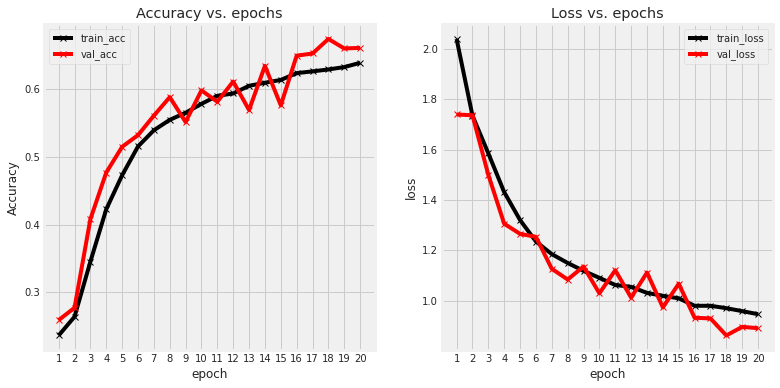

In [35]:
# plotting score and loss

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plot_accuracies(history)
plt.subplot(1, 3, 2)
plot_losses(history)

# plt.subplot(1, 3, 3)
# plot_lrs(history)